NOTE: This notebook is done on Google Colab

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install pickle-mixin
!pip install -U scikit-learn
!pip install xgboost

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [41]:
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

import xgboost as xgb

sns.set_theme(style="darkgrid")

#Load Data

In [5]:
root_path='/content/drive/MyDrive/ML Project/online_shopping_analysis'
data_path=f'{root_path}/processed_data.csv'
label_path=f'{root_path}/data_label.csv'

In [6]:
raw_processed_data = pd.read_csv(data_path)
raw_processed_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,1,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,1,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,1,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,1,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,1,1


In [7]:
data_label = pd.read_csv(label_path)
data_label.head()

,label
0,0
1,0
2,0
3,0
4,0


# Scale data

In [8]:
"""StandarScaler"""
standard_scaler = preprocessing.StandardScaler().fit(raw_processed_data)
standardized_data = standard_scaler.transform(raw_processed_data)
standardized_data

array([[-0.69699296, -0.45773627, -0.39636998, ..., -0.76262903,
        -0.40102509, -0.55055169],
       [-0.69699296, -0.45773627, -0.39636998, ..., -0.51418219,
        -0.40102509, -0.55055169],
       [-0.69699296, -0.46339389, -0.39636998, ..., -0.26573535,
        -0.40102509, -0.55055169],
       ...,
       [-0.69699296, -0.45773627, -0.39636998, ...,  2.21873304,
        -0.40102509,  1.81635987],
       [ 0.50722805, -0.03341489, -0.39636998, ...,  1.72183936,
        -0.40102509, -0.55055169],
       [-0.69699296, -0.45773627, -0.39636998, ..., -0.51418219,
         2.25167844,  1.81635987]])

In [9]:
standardized_data.mean(axis=0)

array([-2.99661170e-17, -9.45085228e-17,  3.22712029e-17,  2.07457733e-17,
        3.68813748e-17, -9.22034369e-18, -3.45762888e-17,  3.91864607e-17,
        1.06033952e-16, -5.53220622e-17, -2.21288249e-16,  4.61017185e-18,
        1.49830585e-17,  7.72203784e-17, -2.99661170e-17, -2.25898420e-16,
        2.30508592e-18])

In [10]:
standardized_data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
"""MaxMINScaler"""
max_min_scaler= preprocessing.MinMaxScaler()
max_min_data = max_min_scaler.fit_transform(raw_processed_data)
max_min_data

array([[0.00000000e+00, 2.94139275e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.94139275e-04, 0.00000000e+00, ...,
        5.26315789e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05263158e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.94139275e-04, 0.00000000e+00, ...,
        6.31578947e-01, 0.00000000e+00, 1.00000000e+00],
       [1.48148148e-01, 2.23545849e-02, 0.00000000e+00, ...,
        5.26315789e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.94139275e-04, 0.00000000e+00, ...,
        5.26315789e-02, 5.00000000e-01, 1.00000000e+00]])

In [12]:
"""MaxAbsScaler for sparse data"""
max_abs_scaler = preprocessing.MaxAbsScaler()
max_abs_data = max_abs_scaler.fit_transform(raw_processed_data)
max_abs_data

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.00000000e-02,  3.33333333e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e-01,  3.33333333e-01,  0.00000000e+00],
       [ 0.00000000e+00, -2.94225818e-04,  0.00000000e+00, ...,
         1.50000000e-01,  3.33333333e-01,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.50000000e-01,  3.33333333e-01,  1.00000000e+00],
       [ 1.48148148e-01,  2.20669364e-02,  0.00000000e+00, ...,
         5.50000000e-01,  3.33333333e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e-01,  6.66666667e-01,  1.00000000e+00]])

In [13]:
"""PowerTransofmr, convert to gaussian distribution"""
power_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
gaussian_data = power_scaler.fit_transform(raw_processed_data)

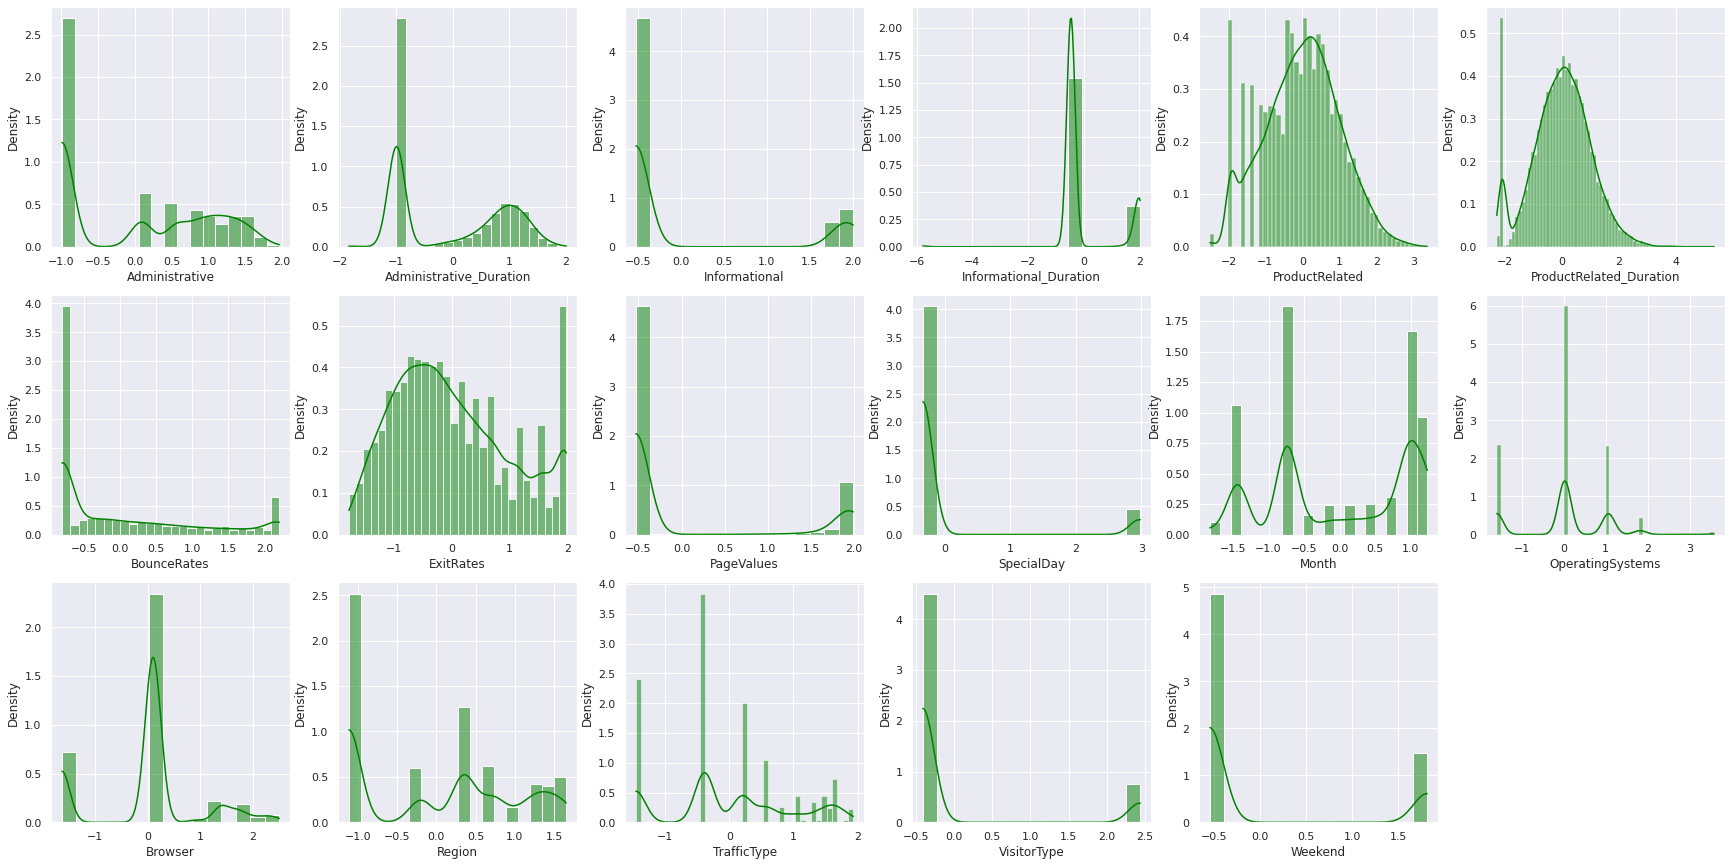

In [14]:
gaussian_data_frame = pd.DataFrame(gaussian_data,columns=raw_processed_data.columns.values)

plt.figure(figsize=(30,15))
for index, col_name in enumerate(gaussian_data_frame.columns.values):
  ax_sub=plt.subplot(3,6, index+1);
  ax_sns = sns.histplot(data=gaussian_data_frame[col_name], ax=ax_sub, kde=True, stat='density', color='green')

In [15]:
"""QuantileTransform, convert to uniform distribution"""
quantile_scaler = preprocessing.QuantileTransformer(random_state=123)
uniform_data = quantile_scaler.fit_transform(raw_processed_data)
uniform_data

array([[0.        , 0.24024024, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.24024024, 0.        , ..., 0.35735736, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.5990991 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.24024024, 0.        , ..., 0.94744745, 0.        ,
        1.        ],
       [0.77327327, 0.70770771, 0.        , ..., 0.90740741, 0.        ,
        0.        ],
       [0.        , 0.24024024, 0.        , ..., 0.35735736, 0.92442442,
        1.        ]])

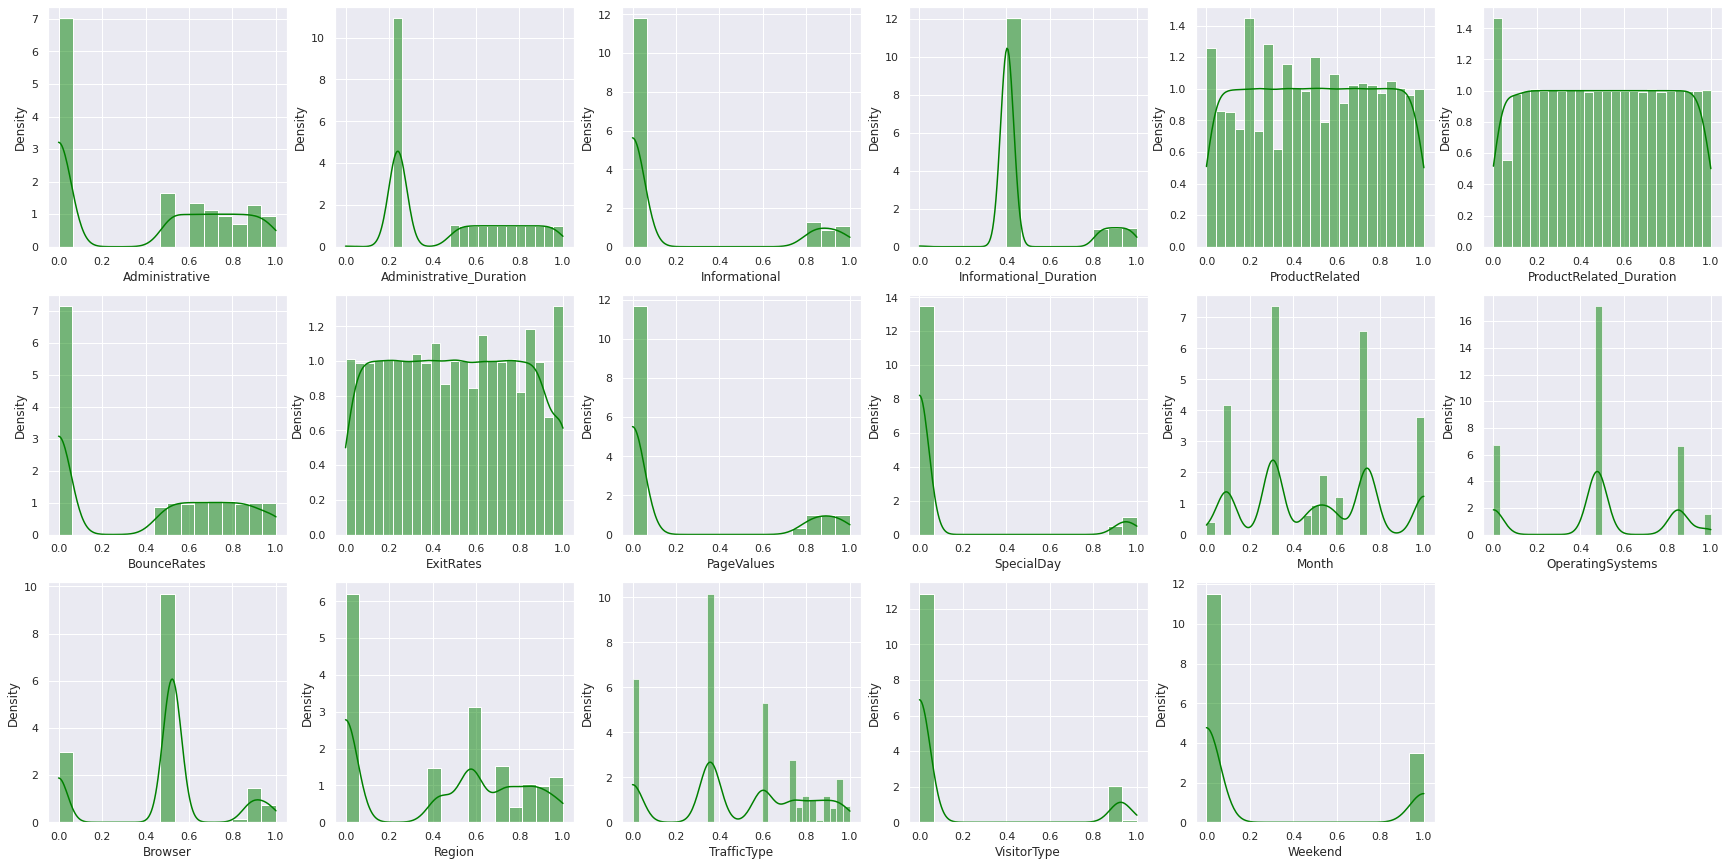

In [16]:
uniform_data_frame = pd.DataFrame(uniform_data,columns=raw_processed_data.columns.values)

plt.figure(figsize=(30,15))
for index, col_name in enumerate(uniform_data_frame.columns.values):
  ax_sub=plt.subplot(3,6, index+1);
  ax_sns = sns.histplot(data=uniform_data_frame[col_name], ax=ax_sub, kde=True, stat='density', color='green')

In [17]:
"""Normalization"""
# l1 norm
l1_scaler = preprocessing.Normalizer(norm='l1')
l1_data = l1_scaler.fit_transform(raw_processed_data)
l1_data

array([[ 0.        ,  0.        ,  0.        , ...,  0.11904762,
         0.11904762,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02628121,
         0.0131406 ,  0.        ],
       [ 0.        , -0.04098361,  0.        , ...,  0.12295082,
         0.04098361,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.05844798,
         0.004496  ,  0.004496  ],
       [ 0.00851026,  0.15956732,  0.        , ...,  0.02340321,
         0.00212756,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.043181  ,
         0.043181  ,  0.0215905 ]])

In [18]:
# l2 norm
l2_scaler = preprocessing.Normalizer(norm='l2')
l2_data = l2_scaler.fit_transform(raw_processed_data)
l2_data

array([[ 0.        ,  0.        ,  0.        , ...,  0.31497039,
         0.31497039,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.03116638,
         0.01558319,  0.        ],
       [ 0.        , -0.09281567,  0.        , ...,  0.27844701,
         0.09281567,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.07020356,
         0.00540027,  0.00540027],
       [ 0.0112758 ,  0.21142116,  0.        , ...,  0.03100844,
         0.00281895,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.08134068,
         0.08134068,  0.04067034]])

In [19]:
# max norm
max_scaler = preprocessing.Normalizer(norm='max')
max_norm_data = max_scaler.fit_transform(raw_processed_data)
max_norm_data

array([[ 0.        ,  0.        ,  0.        , ...,  0.5       ,
         0.5       ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.03125   ,
         0.015625  ,  0.        ],
       [ 0.        , -0.11111111,  0.        , ...,  0.33333333,
         0.11111111,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.07055631,
         0.00542741,  0.00542741],
       [ 0.01156069,  0.21676301,  0.        , ...,  0.03179191,
         0.00289017,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.09411765,
         0.09411765,  0.04705882]])

In [20]:
complete_data_dict ={'standardized_data':standardized_data, 
                     'max_min_data':max_min_data, 
                     'max_abs_data':max_abs_data, 
                     'gaussian_data':gaussian_data, 
                     'uniform_data':uniform_data, 
                     'l1_data':l1_data, 
                     'l2_data':l2_data, 
                     'max_norm_data':max_norm_data}

# GridSearch For Data Modeling

In [42]:
def grid_search_params(complete_data_dict, data_label, grid_params, classifer, path, cv):
  best_params={}
  best_score={}
  best_model={}
  best_matrix={}
  best_roc={}
  best_pre_rec={}

  # grid search
  for index, key in enumerate(complete_data_dict.keys()):
    print('\n')
    print(f'================={key}=====================')
    # load data
    data = complete_data_dict[key]
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data, data_label.values, train_size=0.7, random_state=123, shuffle=True)
    # n-fold verification grid search
    gd_sr = GridSearchCV(estimator=classifer, param_grid=grid_params, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)
    gd_sr = gd_sr.fit(X_train, y_train.reshape(y_train.shape[0]).astype('float32'))
    # collect best params
    best_params[key]=gd_sr.best_params_
    # collect best models
    best_model[f'{key}'] = gd_sr
    # collect confusion matrix
    predict_label = gd_sr.predict(X_test)
    best_matrix[f'{key}'] = confusion_matrix(y_test, predict_label)
    # collect classification metircs(accuracy, precision, recall, f1-score)
    tn, fp, fn, tp = confusion_matrix(y_test, predict_label).ravel()
    acc = tp/(tn+fp+fn+tp)
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    auc = roc_auc_score(y_test, predict_label)
    avg_precision_score = average_precision_score(y_test, predict_label)
    best_score[f'{key}'] = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'auc':auc,
        'avg_precision_score':avg_precision_score
    }
    # collect ROC curves
    fpr, tpr, thresholds = roc_curve(y_test, predict_label)
    best_roc[f'{key}'] ={
        'fpr':fpr,
        'tpr':tpr,
        'thresholds':thresholds,
    }
    # collect precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, predict_label)
    best_pre_rec[f'{key}']={
        'precision':precision,
        'recall':recall,
        'thresholds':thresholds,
    }
  # save best params in the file
  temp_file=open(path, "wb")
  pickle.dump([best_params, best_score, best_model, best_matrix, best_roc, best_pre_rec], temp_file)
  temp_file.close()

  return best_params, best_score, best_model, best_matrix, best_roc, best_pre_rec

In [43]:
def plot_confusion_matrix(complete_data_dict, best_matrix):
  plt.figure(figsize=(40,4))
  for index, key in enumerate(complete_data_dict.keys()):
    ax_sub = plt.subplot(1,8, index+1);
    ax = sns.heatmap(best_matrix[f'{key}'], annot=True, fmt='g',linewidths=.5,  cmap="YlGnBu")
    ax.set_title(f'"{key}" Confusion Matrix')
    ax.set_xlabel('Pred Labels')
    ax.set_ylabel('True Labels') 

  plt.tight_layout()
  plt.show()

In [44]:
def plot_roc_curve(complete_data_dict, best_roc, best_scores):
  plt.figure(figsize=(40,4))
  for index, key in enumerate(complete_data_dict.keys()):
    fpr = best_roc[key]['fpr']
    tpr = best_roc[key]['tpr']
    auc = round(best_scores[key]['auc'],3)
    ax_sub = plt.subplot(1,8,index+1)
    ax_roc = sns.lineplot(x=fpr, y=tpr, color='green')
    ax_roc = sns.lineplot(x=[0,1],y=[0,1], color='red')
    ax_roc.lines[1].set_linestyle("--")
    ax_roc.set_title(f'{key}_ROC (AUC {auc})')
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("Recall")
    ax_roc.legend(['ROC Curve','Random Guess'])
  plt.tight_layout()
  plt.show()

In [45]:
def plot_precision_recall_curve(complete_data_dict, best_pre_rec, best_scores):
  plt.figure(figsize=(40,4))
  for index, key in enumerate(complete_data_dict.keys()):
    precision = best_pre_rec[key]['precision']
    recall = best_pre_rec[key]['recall']
    avg_preg = round(best_scores[key]['avg_precision_score'],2)
    ax_sub = plt.subplot(1,8,index+1)
    ax_roc = sns.lineplot(x=precision, y=recall, color='green')
    ax_roc.set_title(f'{key} PRC (Avg Precision {avg_preg} )')
    ax_roc.set_xlabel("Precision")
    ax_roc.set_ylabel("Recall")
  plt.tight_layout()
  plt.show()

In [46]:
def plot_classification_metrics(best_scores):
  pd.DataFrame(best_scores.values(), index=best_scores.keys()).plot(kind='barh', figsize=(30,12))
  plt.title("Classification Metrics Under Different Scaler")
  plt.xlabel("Value")
  plt.ylabel("Scaler")
  plt.show()

In [25]:
"""Logistic Regression Grid Search Under Each Scaled Data"""
log_reg_params={
    'C':[1,0.1,0.01,0.001,0.0001],
    'penalty': ['l1','l2'], 
    'fit_intercept':[True],
    'intercept_scaling':np.linspace(0.01,10,20),
    'solver':['liblinear'],
    'dual':[False],
    'tol':[1e-4],
    'class_weight':['balanced'],
    'random_state':[123], 
    'max_iter':[200],
    'multi_class':['auto'], 
    'verbose':[1], 
    'warm_start':[False], 
    'n_jobs':[None],
}

log_reg_classifer = LogisticRegression()

path=f"{root_path}/lrc_best_params.pkl"
best_params, best_score, best_model, best_matrix, best_roc, best_pre_rec= grid_search_params(complete_data_dict, data_label, log_reg_params, log_reg_classifer, path, cv=5)



=================standardized_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================max_min_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================max_abs_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================gaussian_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================uniform_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================l1_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================l2_data=====================
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

=================max_norm_data=====================
Fitting 5 folds for each of 200 candidates, totalling 

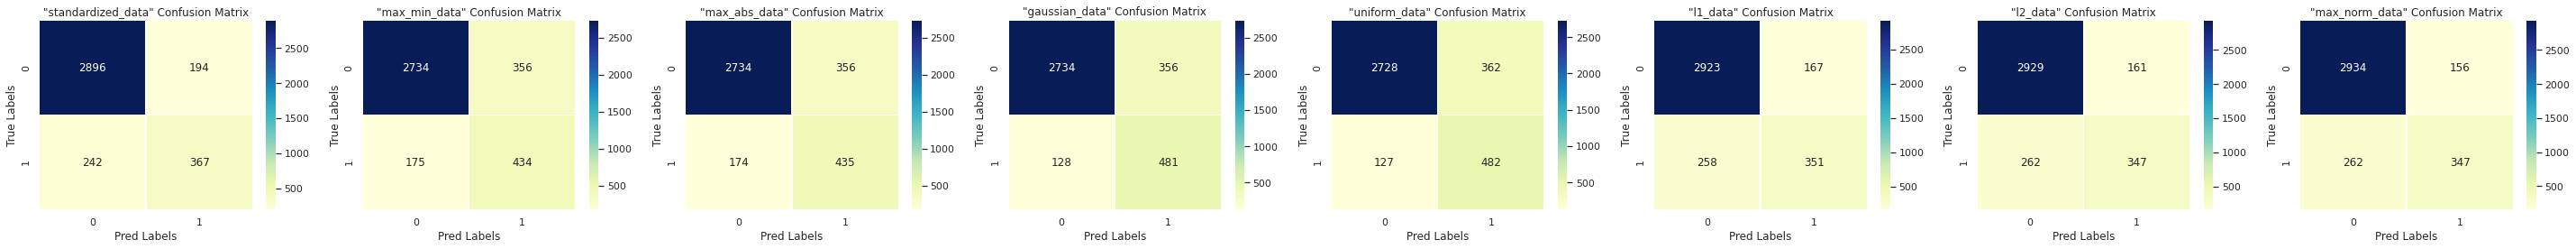

In [26]:
plot_confusion_matrix(complete_data_dict, best_matrix)

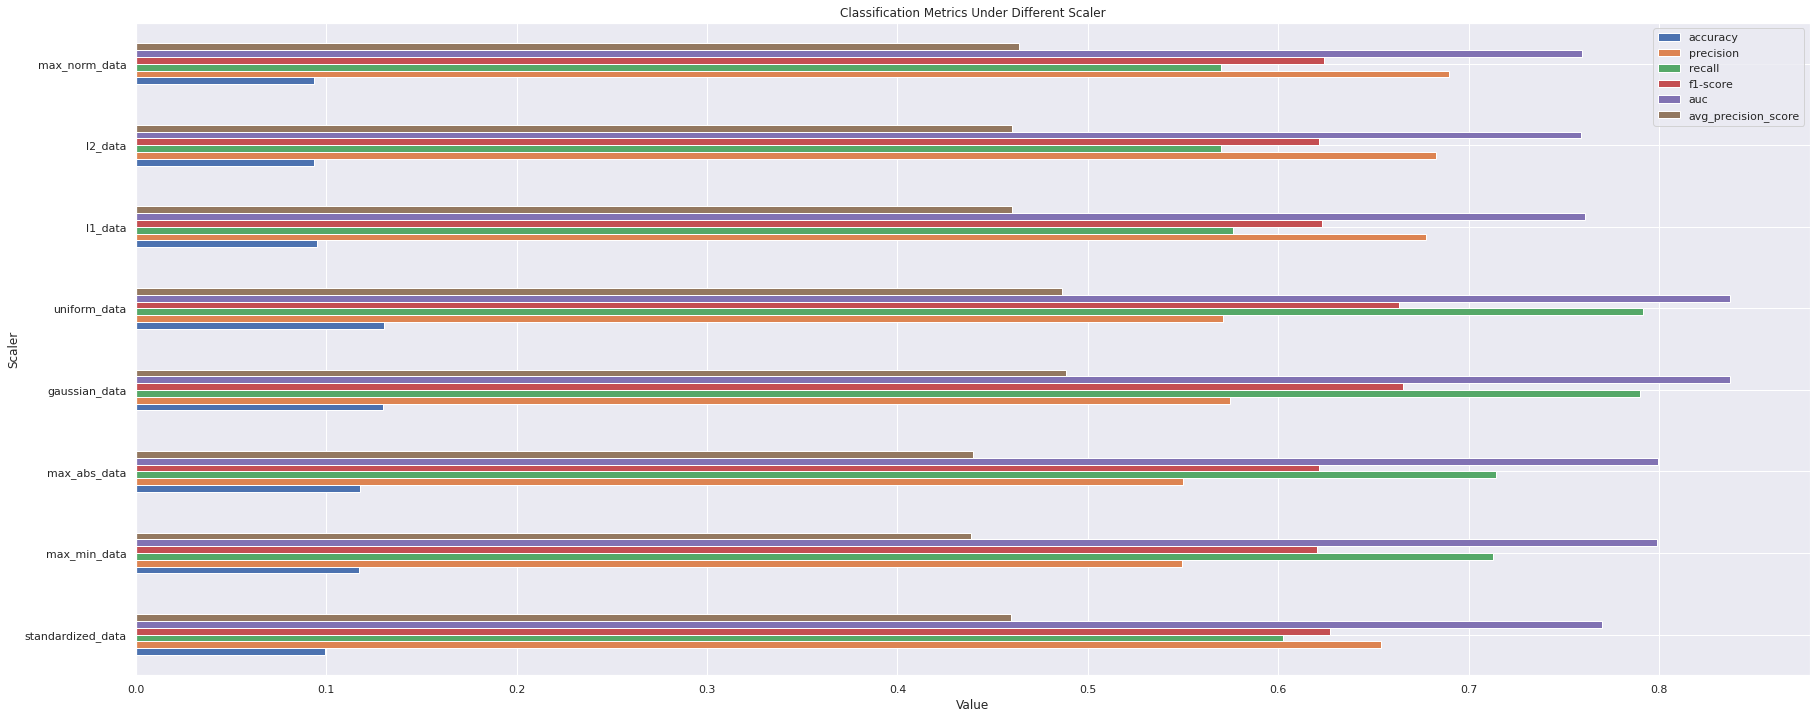

In [28]:
plot_classification_metrics(best_score)

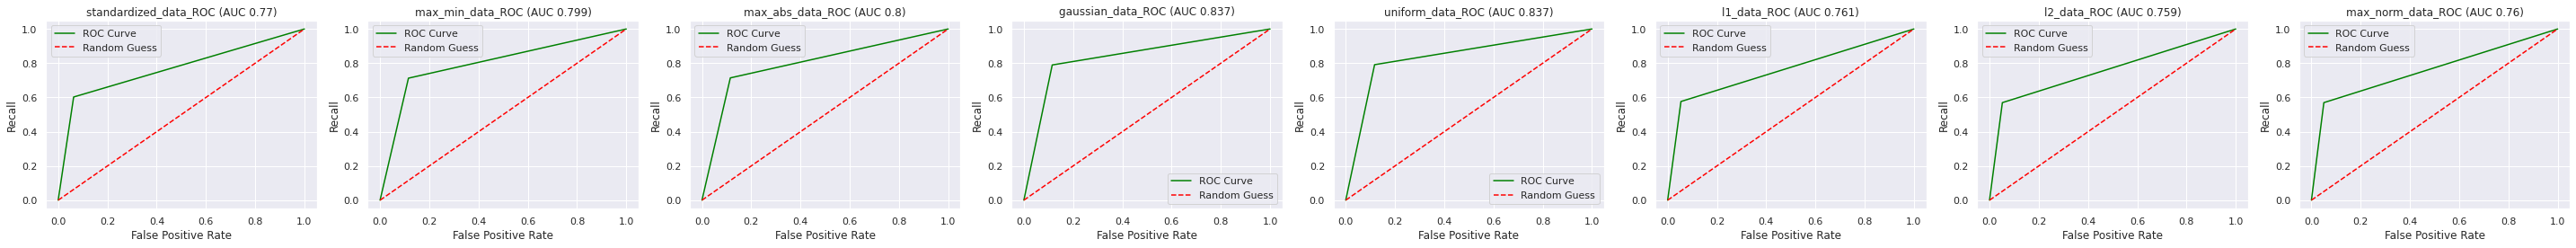

In [29]:
plot_roc_curve(complete_data_dict, best_roc, best_score)

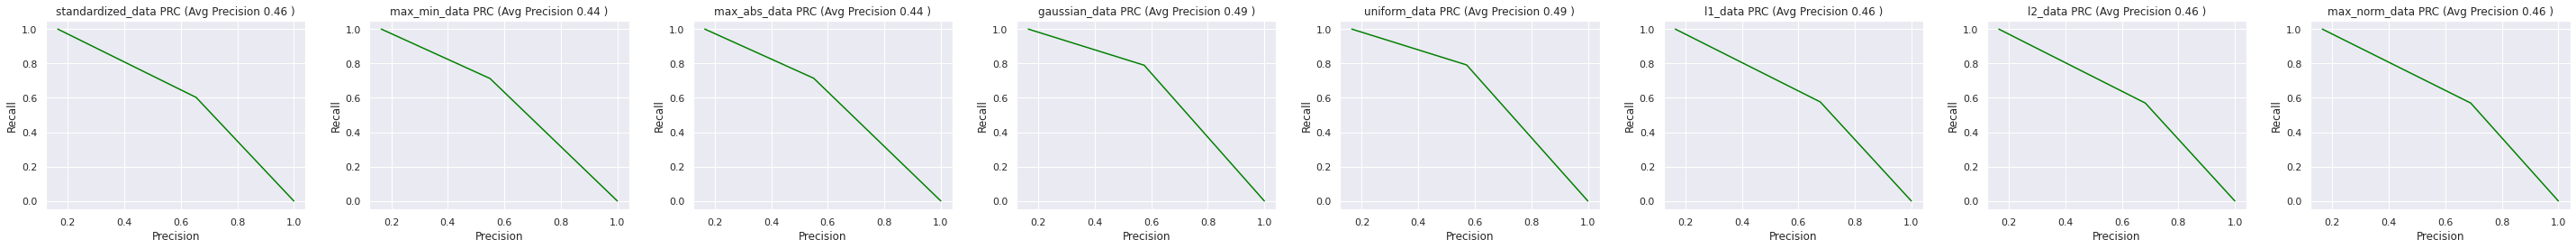

In [30]:
plot_precision_recall_curve(complete_data_dict, best_pre_rec, best_score)

In [31]:
"""SVM Grid Search Under Each Scaled Data"""
svc_params={
    'C': [1,0.1,0.01,0.001,0.0001,0.00001], 
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[2,3,4,5],
}

svc_classifier = SVC(gamma='scale',
                     shrinking=True,
                     probability=False,
                     tol=1e-3,
                     cache_size=200,
                     class_weight='balanced',
                     verbose=True,
                     max_iter=-1,
                     decision_function_shape='ovr',
                     break_ties=False,
                     random_state=123)

path=f"{root_path}/svm_best_params.pkl"
best_params, best_scores, best_model, best_matrix, best_roc, best_pre_rec= grid_search_params(complete_data_dict, data_label, svc_params, svc_classifier, path, cv=5)



=================standardized_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================max_min_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================max_abs_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================gaussian_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================uniform_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================l1_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================l2_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

=================max_norm_data=====================
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LibSVM]

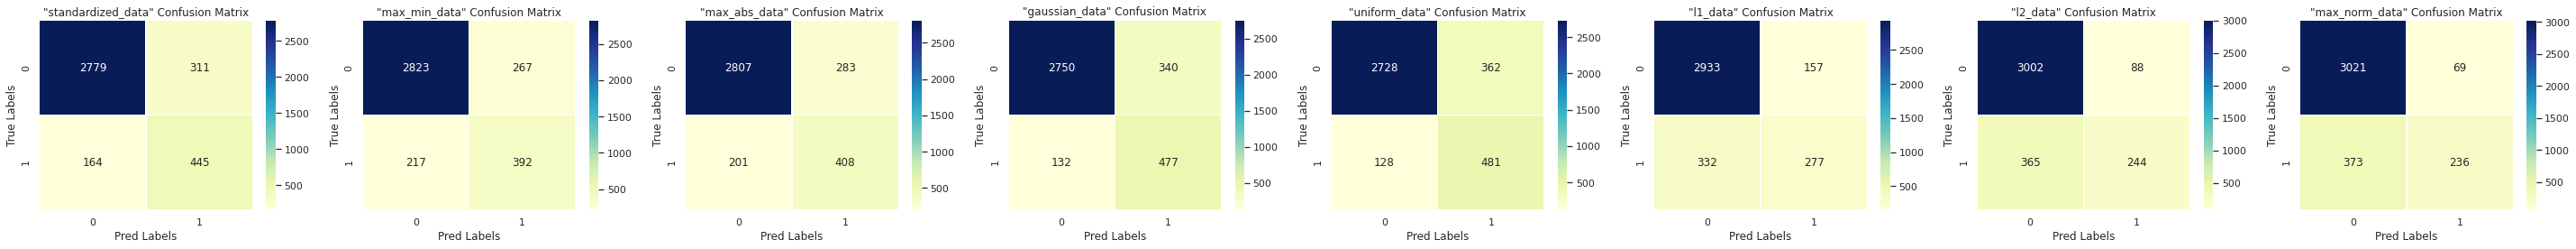

In [32]:
plot_confusion_matrix(complete_data_dict, best_matrix)

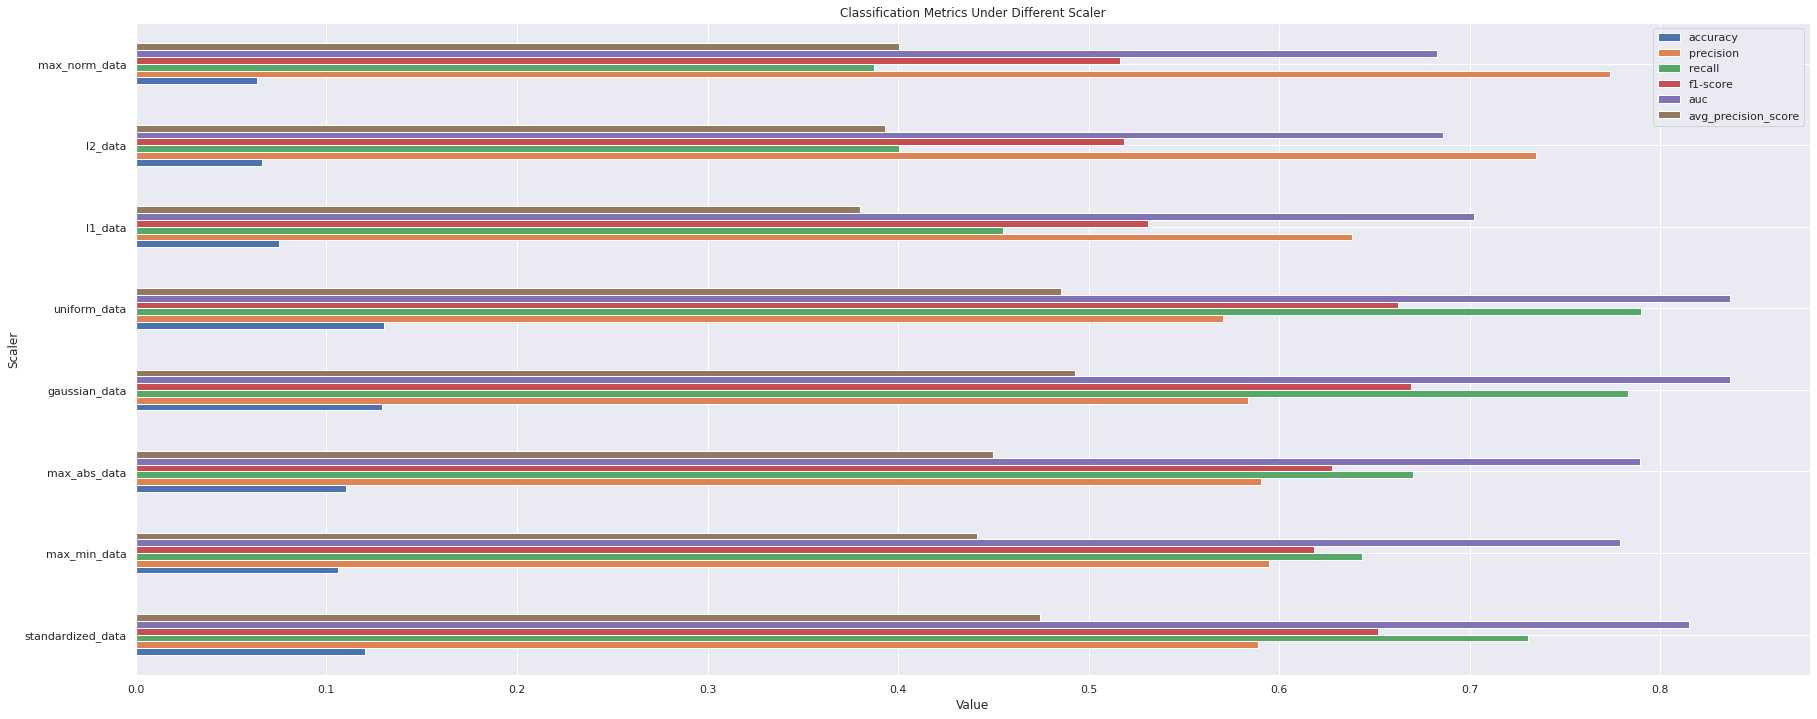

In [33]:
plot_classification_metrics(best_scores)

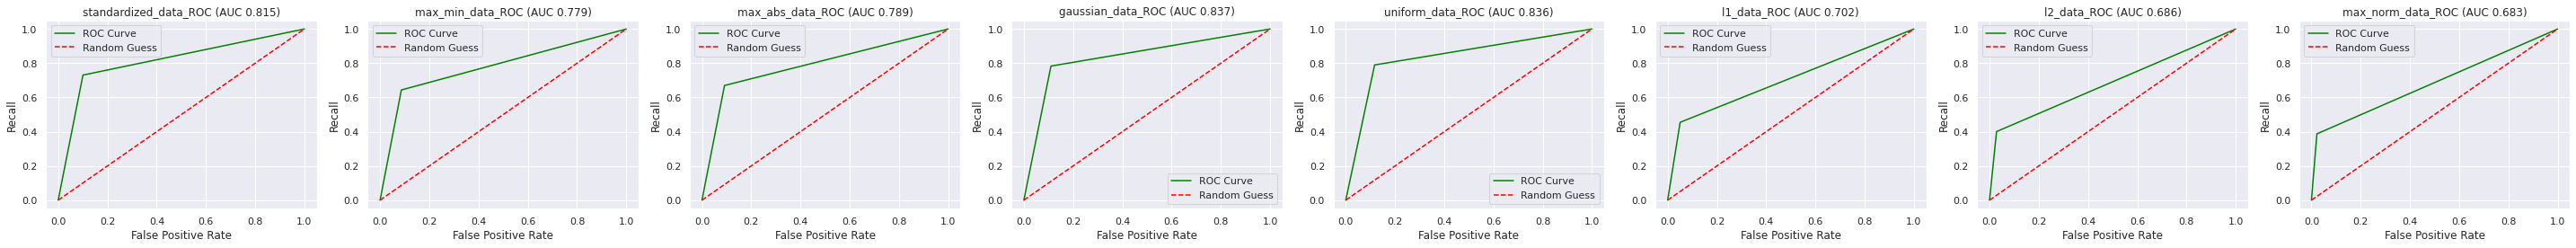

In [34]:
plot_roc_curve(complete_data_dict, best_roc, best_scores)

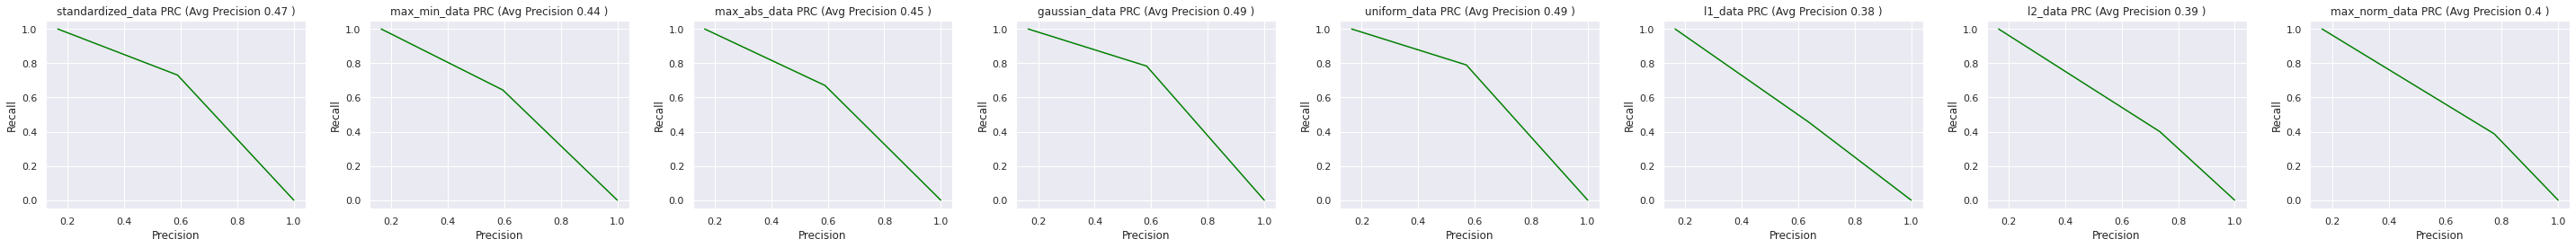

In [35]:
plot_precision_recall_curve(complete_data_dict, best_pre_rec, best_scores)

In [ ]:
"""Random Forests Grid Search Under Each Scaled Data"""
rfc_params={
    'n_estimators':[100, 300, 500, 600],
    'criterion':['gini','entropy'],
    'max_depth':[None],
    'min_samples_split':[2,5,8,10],
    'min_samples_leaf':[1,3,5,7],
    'max_features':['sqrt','log2',None],
    'ccp_alpha':np.linspace(0,0.035,4).tolist(),
}

rf_classifier = RandomForestClassifier(bootstrap=True, 
                                      oob_score=True, 
                                      n_jobs=-1, 
                                      random_state=123, 
                                      verbose=1, 
                                      warm_start=False, 
                                      class_weight='balanced', 
                                      max_samples=None)

path=f"{root_path}/rfc_best_params.pkl"
best_params, best_scores, best_model, best_matrix, best_roc, best_pre_rec= grid_search_params(complete_data_dict, data_label, rfc_params, rf_classifier, path, cv=5)



=================standardized_data=====================
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


In [ ]:
plot_confusion_matrix(complete_data_dict, best_matrix)

In [ ]:
plot_classification_metrics(best_scores)

In [ ]:
plot_roc_curve(complete_data_dict, best_roc, best_scores)

In [ ]:
plot_precision_recall_curve(complete_data_dict, best_pre_rec, best_scores)

In [ ]:
"""KNN Grid Search Under Each Scaled Data"""
knn_params={
    'n_neighbors':np.linspace(1,10,1),
    'weights':[‘uniform’, ‘distance’],
    'algorithm':[‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’],
    'leaf_size':np.linspace(10,100,10),    
    'p':np.linspace(1,3,3),
    }

knn_classifer = KNeighborsClassifier(metric='minkowski', n_jobs=None)

path=f"{root_path}/knn_best_params.pkl"
best_params, best_scores, best_model, best_matrix, best_roc, best_pre_rec= grid_search_params(complete_data_dict, data_label, knn_params, knn_classifier, path, cv=5)

In [ ]:
plot_confusion_matrix(complete_data_dict, best_matrix)

In [ ]:
plot_classification_metrics(best_scores)

In [ ]:
plot_roc_curve(complete_data_dict, best_roc, best_scores)

In [ ]:
plot_precision_recall_curve(complete_data_dict, best_pre_rec, best_scores)

In [ ]:
"""XGBoost Grid Search Under Each Scaled Data"""


In [ ]:
"""load the params"""
temp_file=open(f"{root_path}/lrc_best_params.pkl", "rb")
best_params, best_scores, best_models, best_matrix= pickle.load(temp_file)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
